# Pytorch example

This file shows a minimal pytorch example running on adult data, and demonstrating head-merging.

In general, we strongly recommend that you *do not* use neural networks on tabular data. Boosting is typically higher performing and much faster to run.

However, this is a toy example, and unlike computer vision examples, it will train and run in a matter of minutes. The techniques shown directly apply to computer vision and NLP without modification.

In brief, the steps are:
1. Train a two-headed network.   
    The first head should predict the target attribute using binary cross entropy.  
    The second head should predict binarized protected attributes (use a 1-hot or 0,1 encoding) using mean squared error.
2. Create a FairPredictor using `DeepFairPredictor` with the output of the network on validation data.
3. Call fit to enforce fairness. Use `evaluate_groups` and `plot_frontier` to explore trade-offs. 
4. Finalize the network. Use `merge_heads_pytorch` to generate a fair network with a single head.  
    If you are not using pytorch you can still do this by hand.  
    Call the methods `extract_coefficients` or `extract_coefficients_1_hot` and look at the code in `merge_heads_pytorch` or read the paper for instructions.

In [1]:
# Load libraries

import oxonfair
from oxonfair import group_metrics as gm

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim


In [2]:
#Load adult dataset, using sex as the default groups and discard sex from the raw data
train, val, test = oxonfair.dataset_loader.adult(discard_groups=True)

In [3]:
#Normalise data
std = train['data'].std()
train['data'] = train['data'] / std
val['data'] = val['data'] / std
test['data'] = test['data'] / std

In [4]:
#define a basic nn with 2 hidden-layers. 1 of width 100, and the second width 50.
network = nn.Sequential(nn.Linear(train['data'].shape[1],100),
                        nn.SELU(),
                        nn.Linear(100,50),
                        nn.SELU(),
                        nn.Linear(50,2))

In [5]:
# Define a custom loss that trains the two-heads as required.
def loss(x, y, g):
    output = network(x)
    loss0 = F.binary_cross_entropy_with_logits(output[:,0], y)
    loss1 = F.mse_loss(output[:,1], g)
    return loss0+loss1


In [6]:
# Copy variables to tensors
target = torch.tensor(train['target']).float()
data = torch.tensor(np.asarray(train['data'])).float()
groups = torch.tensor(train['groups']==' Male').float()

optimizer = optim.Adam(network.parameters(), lr=1e-4)
from numpy import random

In [7]:
# Train the network
batch_size = 50

for epoch in range(100):
    #shuffle data
    perm = random.permutation(target.shape[0])
    target = target[perm]
    data = data[perm]
    groups = groups[perm]
    if epoch%10==0:
        print ('epoch is %d'%epoch)
    for step in range(target.shape[0]//batch_size): # This discards the final incomplete batch
        optimizer.zero_grad()
        l = loss(data[step*batch_size:(1+step)*batch_size],
                 target[step*batch_size:(1+step)*batch_size],
                 groups[step*batch_size:(1+step)*batch_size])
        l.backward()
        optimizer.step()

epoch is 0
epoch is 10
epoch is 20
epoch is 30
epoch is 40
epoch is 50
epoch is 60
epoch is 70
epoch is 80
epoch is 90


In [8]:
#convert test['data'] to tensor via numpy and then move the output back to numpy
test_output=np.asarray(network(torch.tensor(np.asarray(test['data'])).float()).detach())


To see if training works we visualize the outputs of the second head (corresponding to gender)

Ideally, this should be a two peaked distribution centered on 0 and 1, with more values at 1 -- corresponding to the male label.

Instead, we find we have 1 peak centered on 1, a broader central peak corresponding to 'don't know' centered around 0.5 and a third smaller peak around 0.2 and 0.

This is fine. The broad central peak reflects the ambiguity of the task, and otherwise we do have something of a split into male and female.

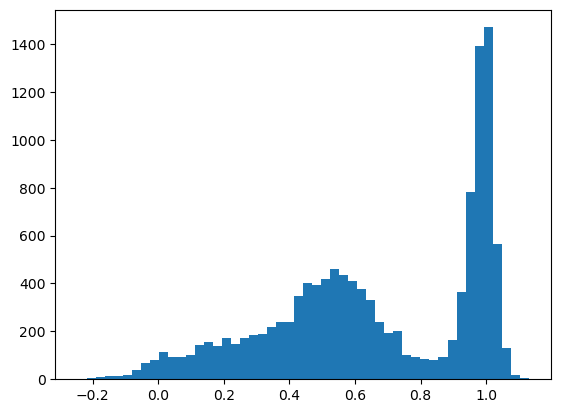

In [9]:
#Plot the outputs of the second head
from matplotlib import pyplot as plt
_=plt.hist(test_output[:,1],bins=50)

In [10]:
#Let's train a fair classifier using the two heads 
#convert val['data'] to tensor via numpy and then move the output back to numpy
val_output = np.asarray(network(torch.tensor(np.asarray(val['data'])).float()).detach())


In [11]:
fpred = oxonfair.DeepFairPredictor(val['target'],
                                   val_output,
                                   groups=val['groups'])
# Enforce fairness on validation data -- i.e. demographic/statistical parity should be within 2 %
fpred.fit(gm.accuracy, gm.demographic_parity, 0.02,grid_width=75)
# Varying the grid with can improve accuracy at the cost of a longer search time.

In [12]:
# Check performance drop
fpred.evaluate()

,original,updated
Accuracy,0.847011,0.831859
Balanced Accuracy,0.737473,0.704057
F1 score,0.622626,0.566420
MCC,0.544495,0.489700
Precision,0.759862,0.739658
Recall,0.527379,0.458932
ROC AUC,0.902655,0.888533


In [13]:
# and fairness
fpred.evaluate_fairness()

,original,updated
Statistical Parity,0.153123,0.019611
Predictive Parity,0.000197,0.270249
Equal Opportunity,0.100120,0.262595
Average Group Difference in False Negative Rate,0.100120,0.262595
Equalized Odds,0.078853,0.145533
Conditional Use Accuracy,0.056217,0.219375
Average Group Difference in Accuracy,0.114673,0.108514
Treatment Equality,0.123767,1.587736


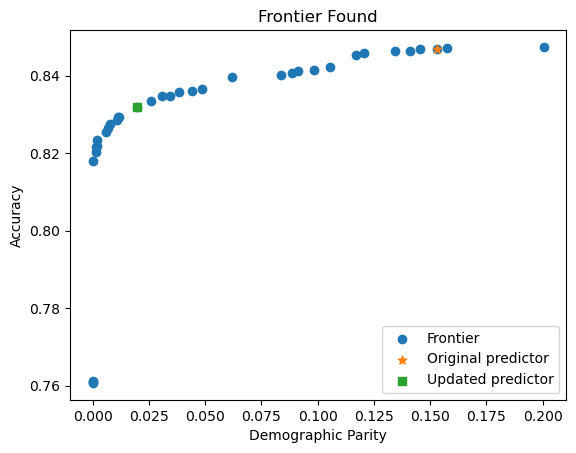

In [14]:
#Visualise the possible trade-offs
fpred.plot_frontier()

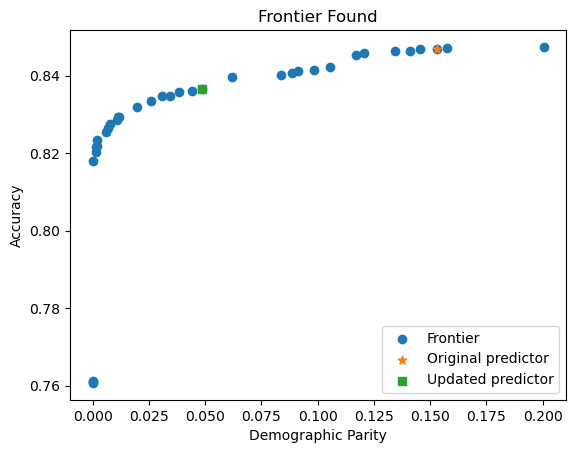

In [15]:
#To quickly select another point from the frontier, you can call it with recompute=False
fpred.fit(gm.accuracy, gm.demographic_parity, 0.05, recompute=False)
fpred.plot_frontier()


In [16]:
# to evaluate how it's working on the test set, we'll create a new dataset holder
test_network = oxonfair.DeepDataDict(test['target'], test_output, test['groups'])

In [17]:
#And evaluate
fpred.evaluate(test_network)

,original,updated
Accuracy,0.850545,0.840799
Balanced Accuracy,0.742136,0.737372
F1 score,0.631090,0.618375
MCC,0.555519,0.529675
Precision,0.770864,0.725138
Recall,0.534223,0.539014
ROC AUC,0.902339,0.888278


In [18]:
fpred.evaluate_fairness(test_network)

,original,updated
Statistical Parity,0.154577,0.046572
Predictive Parity,0.008904,0.245004
Equal Opportunity,0.104299,0.231262
Average Group Difference in False Negative Rate,0.104299,0.231262
Equalized Odds,0.080281,0.124072
Conditional Use Accuracy,0.059483,0.198959
Average Group Difference in Accuracy,0.112338,0.095505
Treatment Equality,0.137020,2.032479


In [19]:
# Now let's merge the heads
# We examine the coefficients first.
fpred.extract_coefficients()

(-2.107, 1.824)

The block below shows the merging step for two groups. 

When only two groups exist, we are using a binary encoding of groups and trying to predict either 0 or 1.
The parameters we learn correspond to a scalar `a`, and bias `b`, and the predictions made by the merging:

    classification_head + a * group_head +b

should be fair and performant.

When more than two groups exist, you should have trained the second head to output a one-hot encoding of the groups and the merging:

    classification_head + a.dot(group_head)

should be fair and performant.

In [20]:
# We copy the network and create a fair version
import copy
fair_network = copy.deepcopy(network)
# We replace the final linear layer with a 1 dimensional head.
fair_network[-1] = fpred.merge_heads_pytorch(network[-1])

In [21]:
# Now let's check the fair classifier on the test set.
test_fair_output=np.asarray(fair_network(torch.tensor(np.asarray(test['data'])).float()).detach())

In [22]:
# As expected the accuracy is identical to what was reported before.
oxonfair.performance.evaluate(test['target'],test_fair_output.reshape(-1))

Accuracy             0.840799
Balanced Accuracy    0.737372
F1 score             0.618375
MCC                  0.529675
Precision            0.725138
Recall               0.539014
ROC AUC              0.888278
Name: 0, dtype: float64

In [23]:
# And so is the fairness
oxonfair.performance.evaluate_fairness(test['target'],test_fair_output.reshape(-1),test['groups'])

Statistical Parity                                 0.046572
Predictive Parity                                  0.245004
Equal Opportunity                                  0.231262
Average Group Difference in False Negative Rate    0.231262
Equalized Odds                                     0.124072
Conditional Use Accuracy                           0.198959
Average Group Difference in Accuracy               0.095505
Treatment Equality                                 2.032479
Name: 0, dtype: float64

In [24]:
# Finally, let's compare to a range of other oxonfair based classifiers.
# These don't support head merging
# 1. The base method that just picks the most likely group label instead of keeping track of the value returned 
fpred_standard = oxonfair.DeepFairPredictor(val['target'],
                                              val_output,
                                              groups=val['groups'], use_fast=True)
# 2. A classifier that enforces fairness by using the actual group labels instead of inferred.
fpred_true_groups = oxonfair.DeepFairPredictor(val['target'],
                                              val_output,
                                              groups=val['groups'], use_fast=True,use_actual_groups=True)


# 3. Single threshold. This adjusts the global bias only, without considering group membership.
# It works surprisingly well for criteria like recall.min, but is less useful for fairness
fpred_thresh  = oxonfair.DeepFairPredictor(val['target'],
                                              val_output,
                                              groups=val['groups'], use_actual_groups='single_threshold')


In [25]:
fpred_standard.fit(gm.accuracy,gm.demographic_parity,0.05)
fpred_true_groups.fit(gm.accuracy,gm.demographic_parity,0.05)
fpred_thresh.fit(gm.accuracy,gm.demographic_parity,0.05)

Fewer groups used (1) in infered groups than in the true groups (2)


(0.75, 0.8792014742014742)

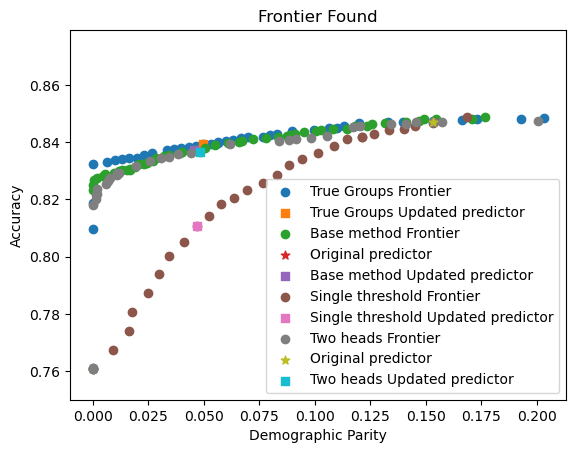

In [26]:
# Plot of curves on validation data
# This shows that the first three approaches are basically interchangable
fpred_true_groups.plot_frontier(prefix='True Groups ', new_plot=False, show_original=False)
fpred_standard.plot_frontier(prefix='Base method ', new_plot=False)
fpred_thresh.plot_frontier(prefix='Single threshold ', new_plot=False, show_original=False)
fpred.plot_frontier(prefix='Two heads ', new_plot=False)
plt.ylim(bottom=0.75)